In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import eda_helper_functions as ehf

from sklearn.ensemble import IsolationForest

In [2]:
file_path = r"C:\Users\Aayush\Desktop\Flight Fare Prediction\data\train.csv"

train = pd.read_csv(file_path)

In [3]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-09,Kolkata,Banglore,21:10:00,18:15:00,1265,1.0,No Info,14571
1,Jet Airways,2019-03-18,Banglore,New Delhi,18:40:00,07:40:00,780,1.0,In-flight meal not included,10972
2,Jet Airways,2019-05-24,Mumbai,Hyderabad,02:55:00,04:20:00,85,0.0,In-flight meal not included,4995
3,Indigo,2019-06-24,Banglore,Delhi,07:10:00,10:05:00,175,0.0,No Info,4823
4,Jet Airways,2019-05-09,Delhi,Cochin,20:55:00,19:00:00,1325,1.0,In-flight meal not included,12373
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-03-27,Delhi,Cochin,06:40:00,12:00:00,320,1.0,No Info,5298
636,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670
637,Multiple Carriers,2019-05-09,Delhi,Cochin,17:00:00,01:30:00,510,1.0,No Info,9424
638,Indigo,2019-05-09,Mumbai,Hyderabad,19:05:00,20:35:00,90,0.0,No Info,4392


In [4]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [5]:
train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
    for col in ["date_of_journey", "dep_time", "arrival_time"]
})

## 3. High-Level  Summary of Data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [7]:
train.describe(include='number')

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,643.562500,0.815625,9052.198437
std,508.558562,0.662243,4626.768232
min,80.000000,0.000000,1965.000000
25%,170.000000,0.000000,5200.250000
50%,522.500000,1.000000,8114.500000
75%,935.000000,1.000000,12373.000000
max,2280.000000,3.000000,36983.000000


In [8]:
train.assign(total_stops=train.loc[:, "total_stops"].astype(object))

(
    train
    .assign(total_stops = train.loc[:, "total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,9,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,220,268,268,353.0,497


- In `total_stops` almost half the values are `1`

## 4. High-Level Analysis of Missing Values 

In [9]:
def missing_info(data):
    na_cols = [col for col in data.columns if data[col].isna().any()]
    na_count = [col.isna().sum() for col in na_cols]
    na_per = [col.isna().mean() for col in na_cols]

    return (
        pd.DataFrame(data={
            'variable': na_cols,
            'count': na_count,
            'percentage': na_per
        })
        .sort_values(by='count', ascending=False)
        .set_index('variable')
    )

In [10]:
missing_info(train)

,count,percentage
variable,,


In [11]:
def rotate_xlabels(ax, angle=35):
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotate=angle,
        ha='right'
    )

In [12]:
def plot_missing_info(data, figsize=(10, 4), bar_label_params=dict()):
    na_data = missing_info(data)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    bar = ax.bar(
        range(len(na_data)),
        height=na_data['count'],
        color = 'skyblue',
        edgecolor = 'black',
        tick_label = na_data.index.to_list()
    )

    ax.bar_label(
        bar,
        **bar_label_params
    )

    ax.set(
        xlabel='Variable',
        ylabel='Count',
        title='Missing Data Counts per Variable'
    )

    rotate_xlabels(ax)
    plt.tight_layout()
    plt.show()

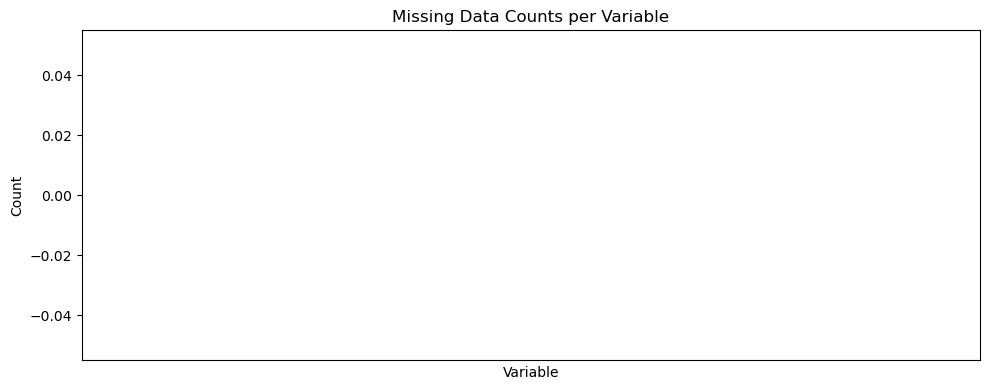

In [13]:
plot_missing_info(train)

## 5. High-level analysis of Outliers

In [14]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [15]:
(
    train
    .assign(
        outlier = forest.fit_predict(
            train
            .drop(columns='price')
            .select_dtypes(include='number')
        )
    )
    .query("outlier == -1")
    # .duration
    # .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Jet Airways,2019-06-09,Kolkata,Banglore,2025-01-22 21:10:00,2025-01-22 18:15:00,1265,1.0,No Info,14571,-1
2,Jet Airways,2019-05-24,Mumbai,Hyderabad,2025-01-22 02:55:00,2025-01-22 04:20:00,85,0.0,In-flight meal not included,4995,-1
4,Jet Airways,2019-05-09,Delhi,Cochin,2025-01-22 20:55:00,2025-01-22 19:00:00,1325,1.0,In-flight meal not included,12373,-1
11,Air India,2019-05-09,Kolkata,Banglore,2025-01-22 14:30:00,2025-01-22 23:15:00,525,2.0,No Info,14214,-1
16,Jet Airways,2019-06-09,Banglore,Delhi,2025-01-22 19:50:00,2025-01-22 22:50:00,180,0.0,In-flight meal not included,7229,-1
...,...,...,...,...,...,...,...,...,...,...,...
629,Air India,2019-05-18,Delhi,Cochin,2025-01-22 17:15:00,2025-01-22 19:15:00,1560,2.0,No Info,12392,-1
632,Air India,2019-06-01,Delhi,Cochin,2025-01-22 10:55:00,2025-01-22 19:15:00,500,2.0,No Info,13013,-1
633,Jet Airways,2019-06-12,Kolkata,Banglore,2025-01-22 08:25:00,2025-01-22 10:05:00,1540,1.0,In-flight meal not included,8529,-1
638,Indigo,2019-05-09,Mumbai,Hyderabad,2025-01-22 19:05:00,2025-01-22 20:35:00,90,0.0,No Info,4392,-1


## 6. Pair Plots

In [16]:
def pair_plots(
    data,
    height=3,
    aspect=1.5,
    hue=None,
    legend=False  
):

    pair_grid = sns.PairGrid(
        data=data,
        aspect=aspect,
        height=height,
        hue=hue,
        corner=False
    )
    
    pair_grid.map_lower(sns.scatterplot)

    if legend:
        pair_grid.add_legend()

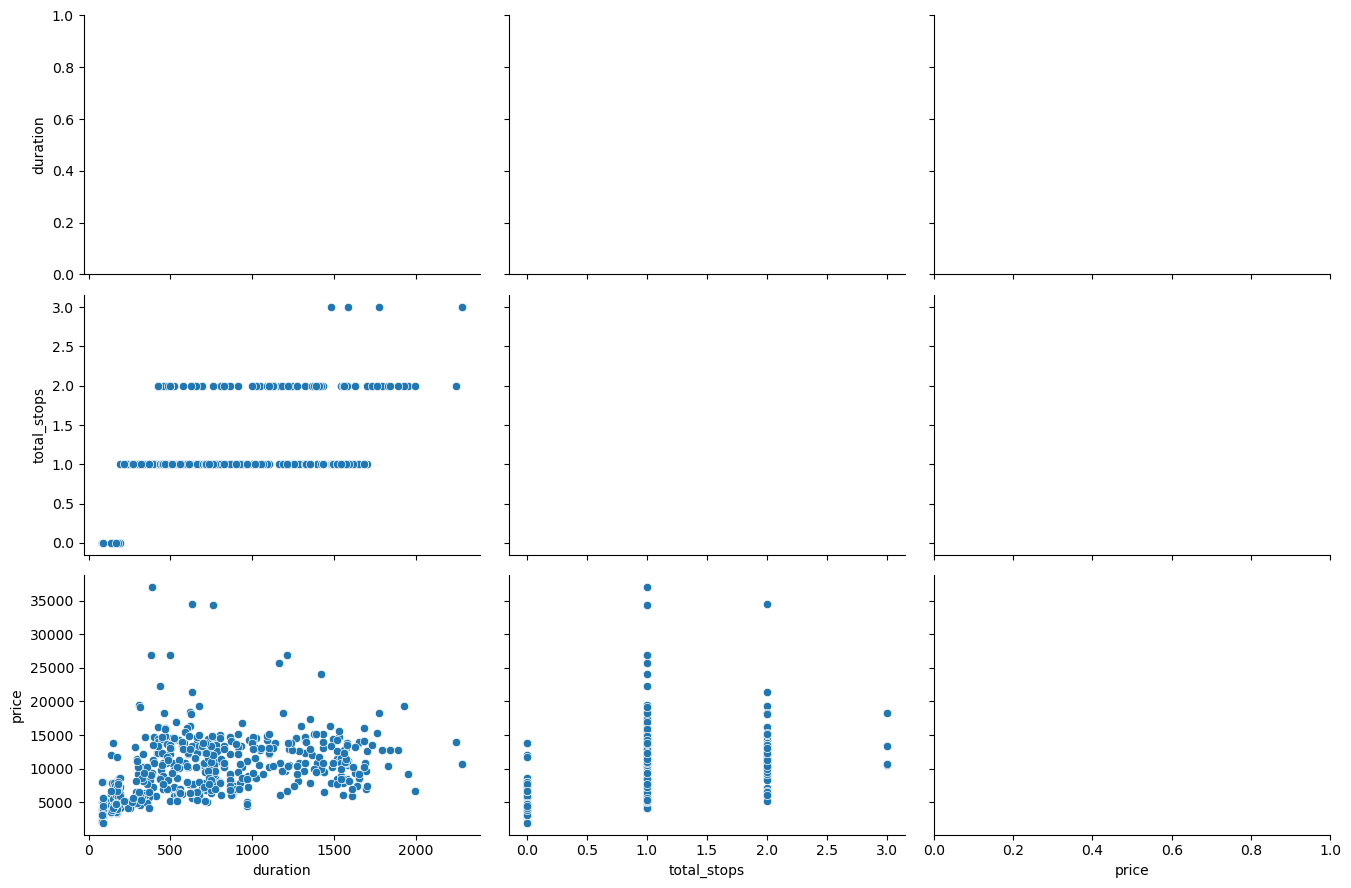

In [17]:
pair_plots(train)

## 7. Correlation Analysis

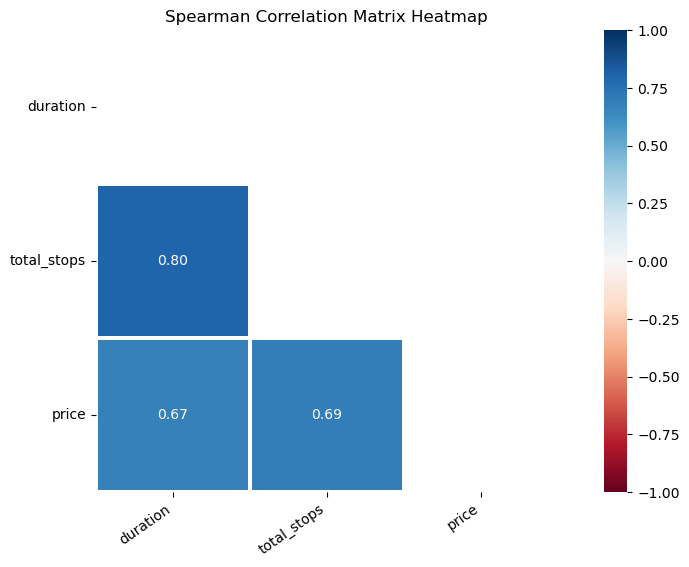

In [18]:
ehf.correlation_heatmap(train)

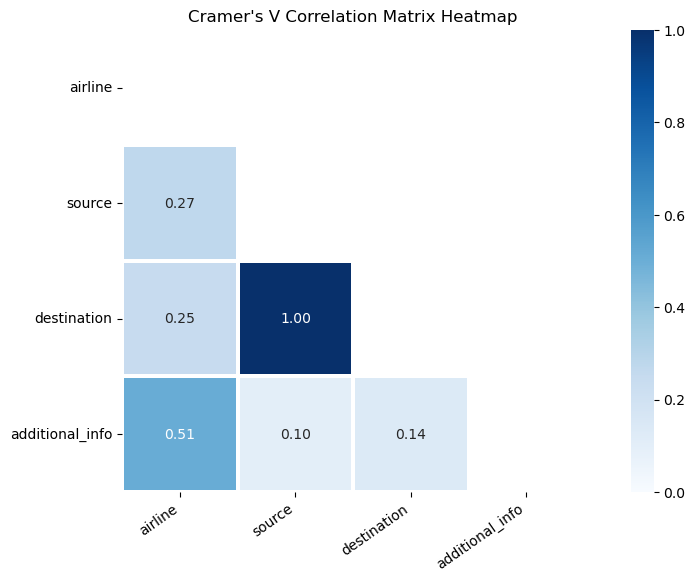

In [19]:
ehf.cramersV_heatmap(train)

## 8. Detailed Analysis

### 8.1 airline

In [20]:
train.airline


0            Jet Airways
1            Jet Airways
2            Jet Airways
3                 Indigo
4            Jet Airways
             ...        
635               Indigo
636    Multiple Carriers
637    Multiple Carriers
638               Indigo
639             Spicejet
Name: airline, Length: 640, dtype: object

In [21]:
ehf.cat_summary(train, 'airline')

0            Jet Airways
1            Jet Airways
2            Jet Airways
3                 Indigo
4            Jet Airways
             ...        
635               Indigo
636    Multiple Carriers
637    Multiple Carriers
638               Indigo
639             Spicejet
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,9
top,Jet Airways
freq,220


,count,percentage
category,,
Jet Airways,220,0.343750
Indigo,119,0.185938
Air India,108,0.168750
Multiple Carriers,72,0.112500
Spicejet,48,0.075000
Vistara,34,0.053125
Air Asia,25,0.039062
Goair,13,0.020313
Trujet,1,0.001563


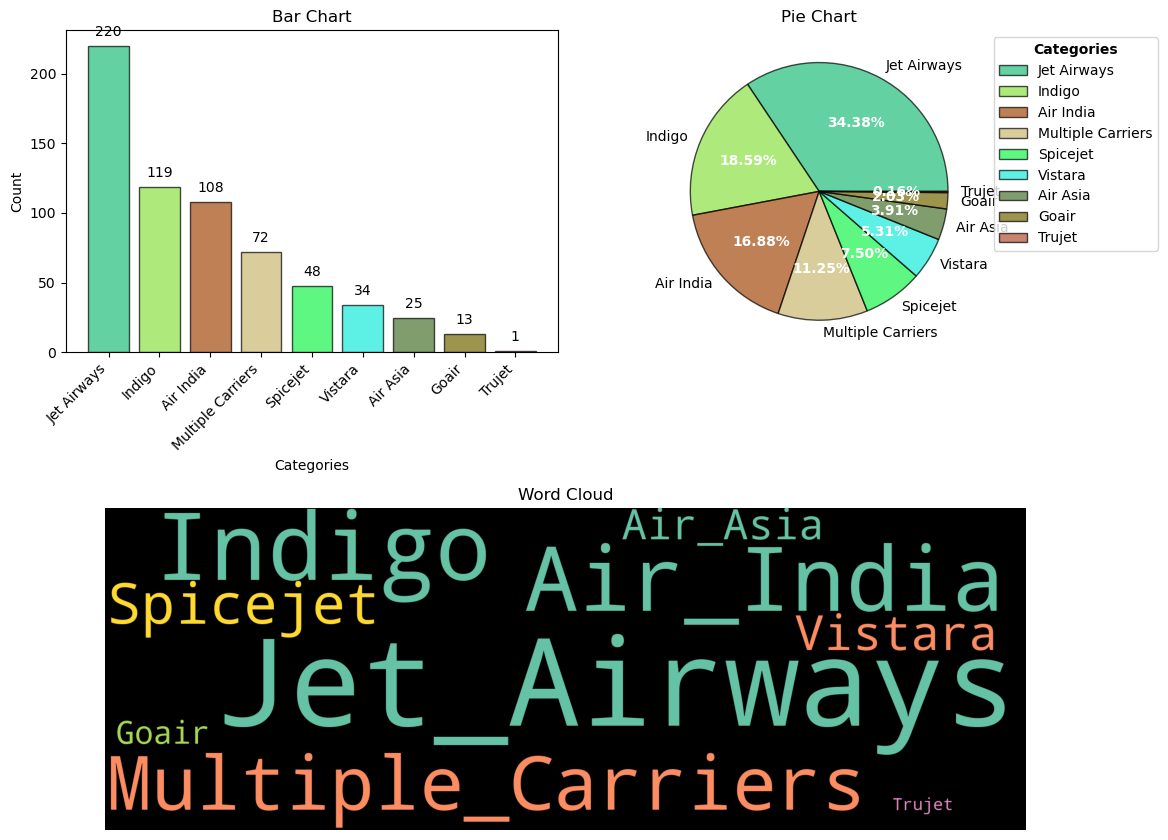

In [22]:
ehf.cat_univar_plots(train, "airline")

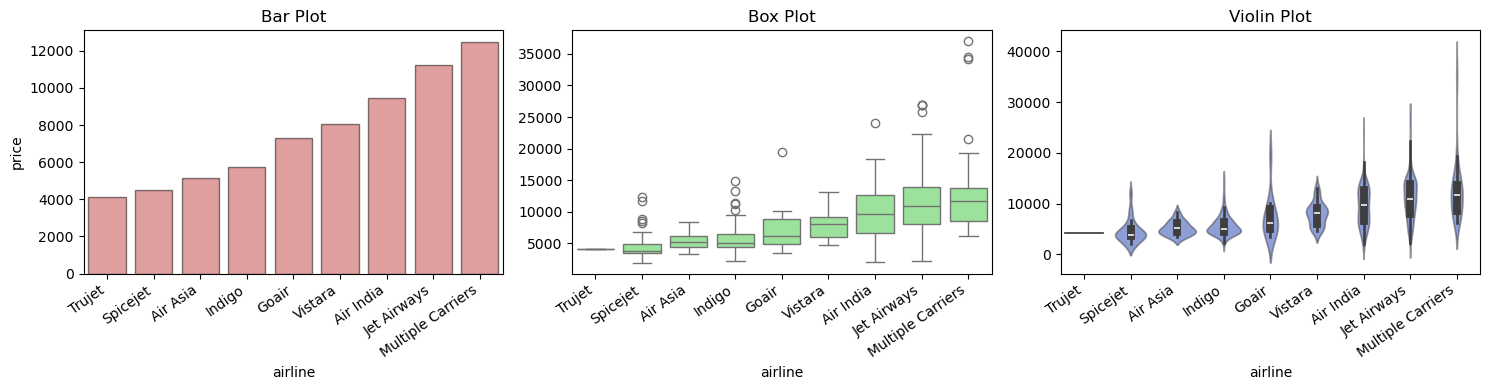

In [23]:
ehf.num_cat_bivar_plots(
    data=train,
    num_var="price",
    cat_var="airline"
)

In [24]:
ehf.num_cat_hyp_testing(
    data=train,
    num_var="price",
    cat_var="airline"
)

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 41.374272567078705
- p-value              : 3.6580243257803444e-53
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 275.3027155724487
- p-value              : 7.352992294971265e-55
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


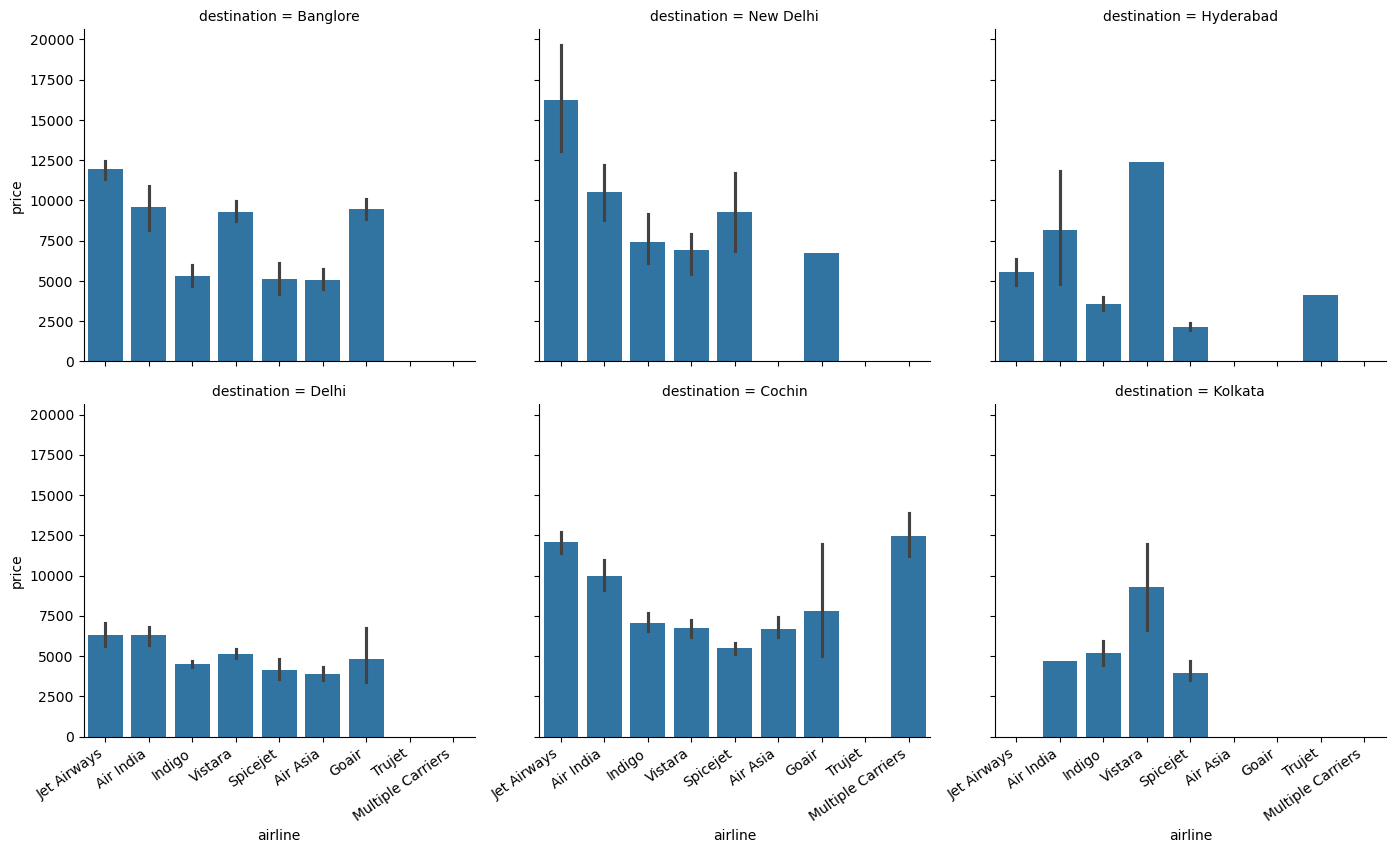

In [25]:
airline_grid = sns.FacetGrid(
    data = train,
    col="destination",
    height=4,
    aspect=1.2,
    col_wrap=3,
    sharey=True,
)

airline_grid.map(sns.barplot, "airline","price")
for ax in airline_grid.axes[-3:]:
    ehf.rotate_xlabels(ax)
    

### 8.2 Date of Jouorney

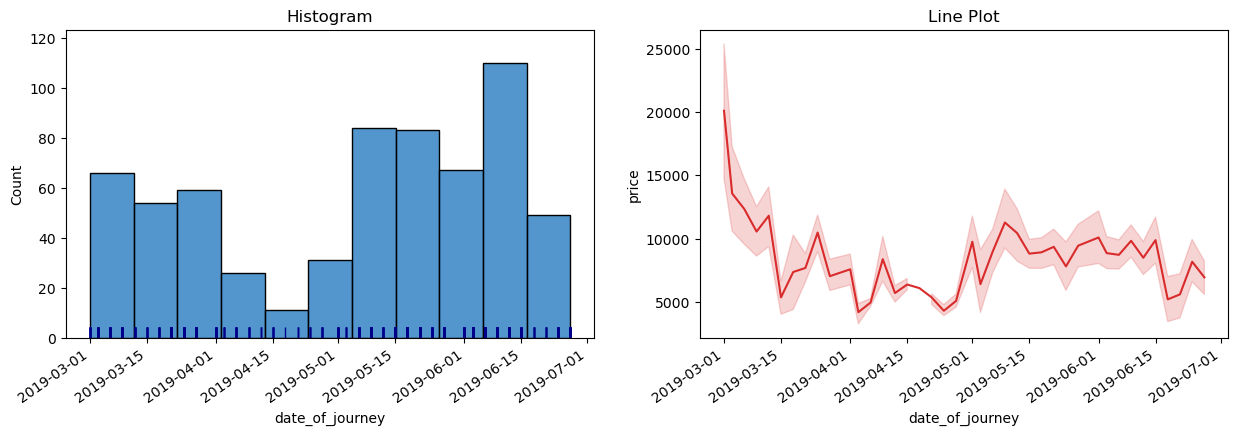

In [26]:
ehf.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

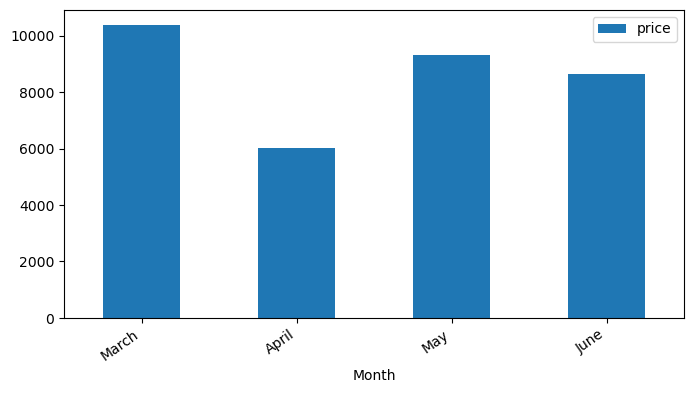

In [27]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="M"))
    .price
    .mean()
    .to_frame()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="Month")
    .plot(
        kind="bar", 
        figsize=(8, 4)
    )
)
ax = plt.gca()
ehf.rotate_xlabels(ax)

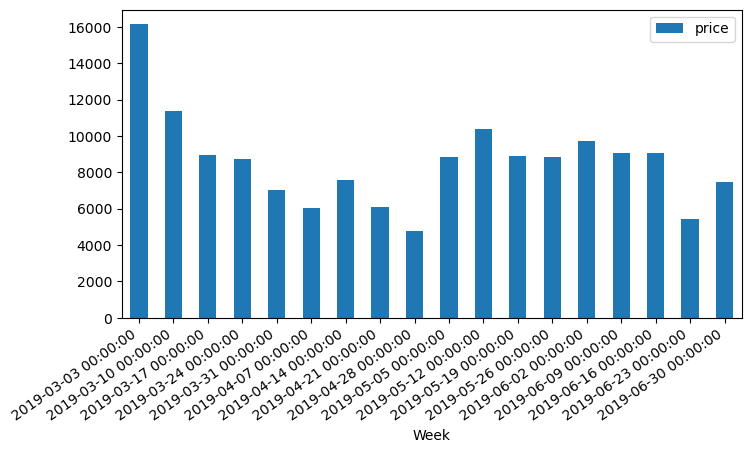

In [28]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="W"))
    .price
    .mean()
    .to_frame()
    .rename_axis(index="Week")
    .plot(
        kind="bar",
        figsize=(8, 4)
    )
    
)
ax = plt.gca()
ehf.rotate_xlabels(ax)

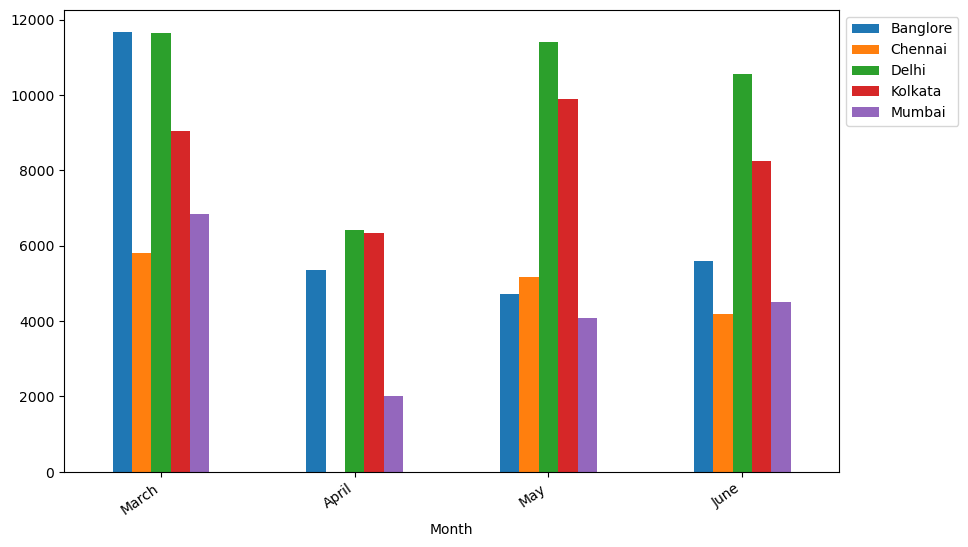

In [29]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
    .price
    .mean()
    .unstack()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="Month")
    .plot(
        kind="bar",
        figsize=(10, 6)
    )
)

ax = plt.gca()
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1)
)
ehf.rotate_xlabels(ax)

### 8.3 dep_time

In [30]:
train.dep_time

0     2025-01-22 21:10:00
1     2025-01-22 18:40:00
2     2025-01-22 02:55:00
3     2025-01-22 07:10:00
4     2025-01-22 20:55:00
              ...        
635   2025-01-22 06:40:00
636   2025-01-22 08:45:00
637   2025-01-22 17:00:00
638   2025-01-22 19:05:00
639   2025-01-22 22:45:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

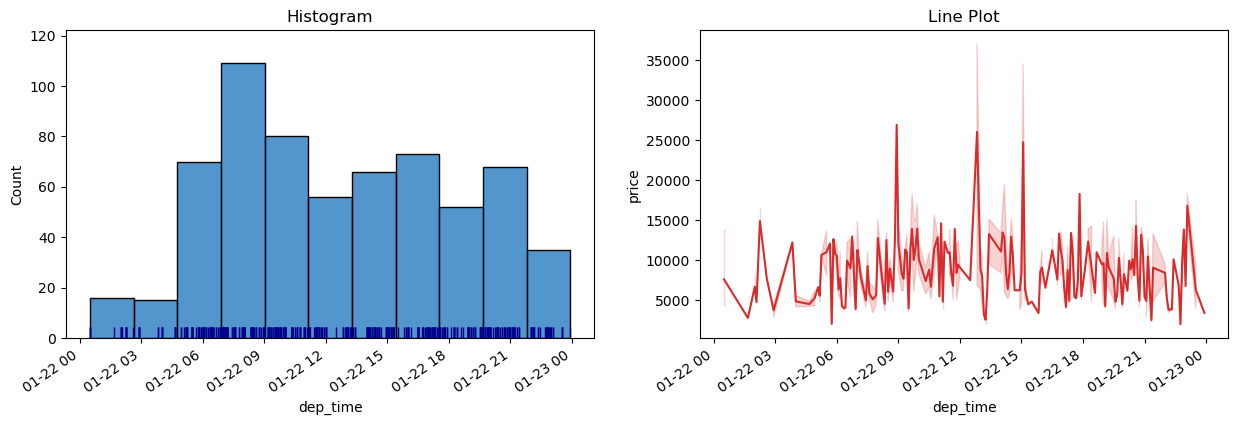

In [31]:
ehf.dt_univar_plots(train, var="dep_time", target="price")

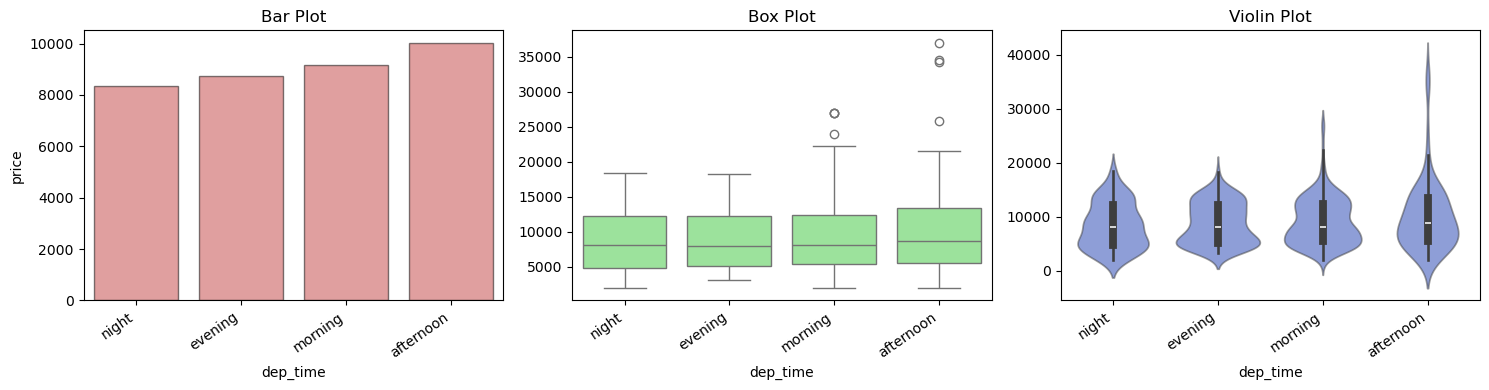

In [32]:
(
    train
    .assign(
        dep_time = lambda df_: np.select(
        [
            df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
            df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
            df_.dep_time.dt.hour.between(16, 20, inclusive="left")
        ],
        [
            "morning",
            "afternoon",
            "evening"
        ],
        default="night"
    )
    )
    .pipe(ehf.num_cat_bivar_plots, "price", "dep_time")
       
    
)

### 8.4 Duration

In [33]:
train.duration

0      1265
1       780
2        85
3       175
4      1325
       ... 
635     320
636     735
637     510
638      90
639      90
Name: duration, Length: 640, dtype: int64

In [34]:
ehf.num_summary(train, "duration")

0      1265
1       780
2        85
3       175
4      1325
       ... 
635     320
636     735
637     510
638      90
639      90
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,80.0
5,90.0
10,140.0
25,170.0
50,522.5
75,935.0
90,1497.0
95,1610.0
99,1870.5


,value
mean,643.562500
trimmed mean (5%),611.467014
trimmed mean (10%),583.271484
median,522.500000


,value
var,258631.811424
std,508.558562
IQR,765.000000
mad,352.500000
coef_variance,0.790224


,value
skewness,0.840104
kurtosis,-0.287155


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 4.3709697860331865e-21
Test Statistic       : 0.8885130403798824
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 23.369581271641664
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


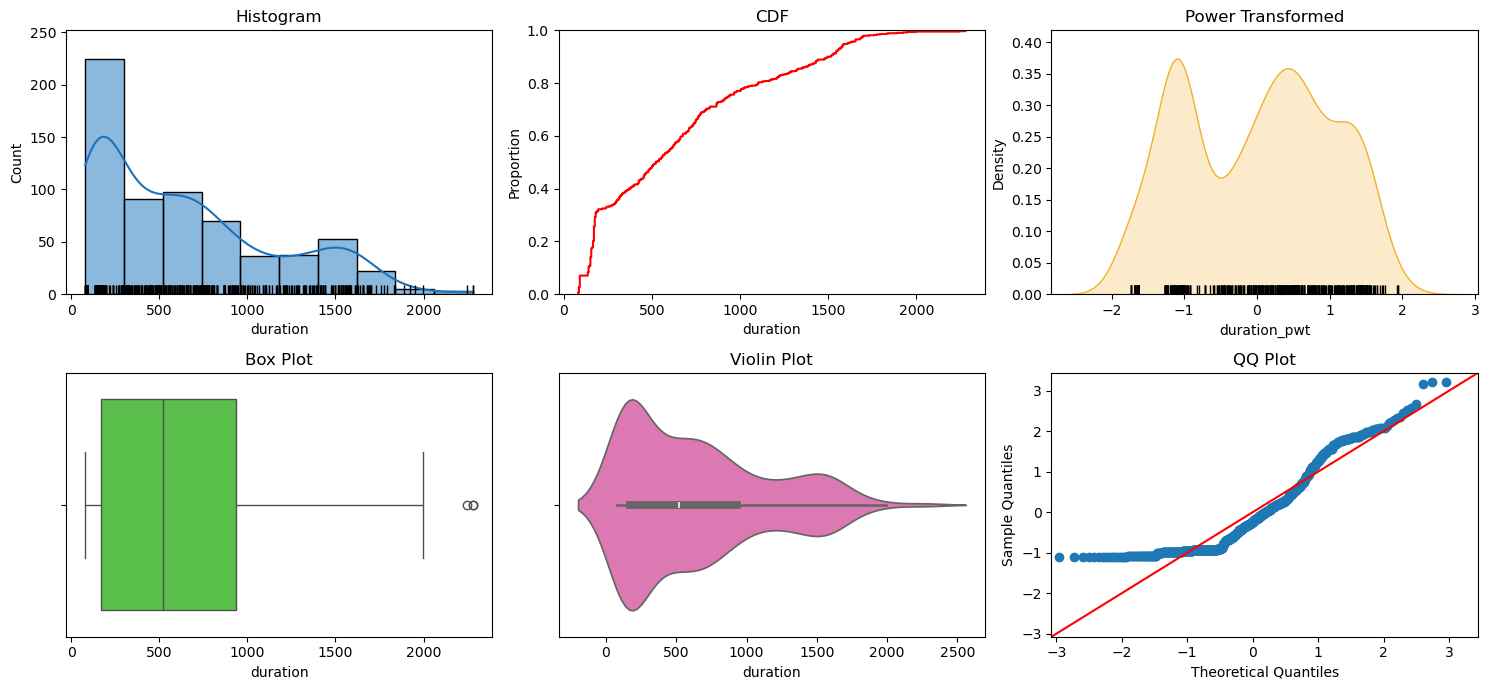

In [35]:
ehf.num_univar_plots(train, "duration")

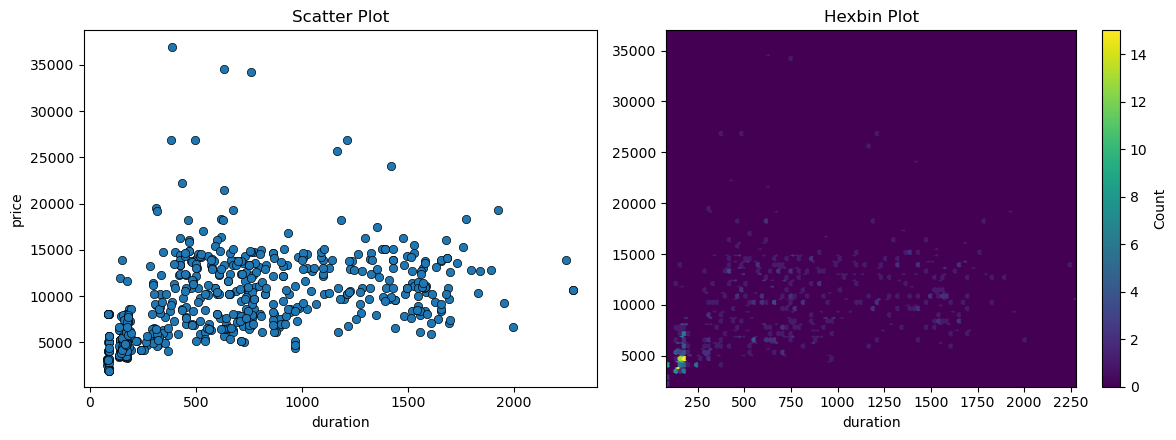

In [36]:
ehf.num_bivar_plots(
    train,
    "duration",
    "price"
    
)

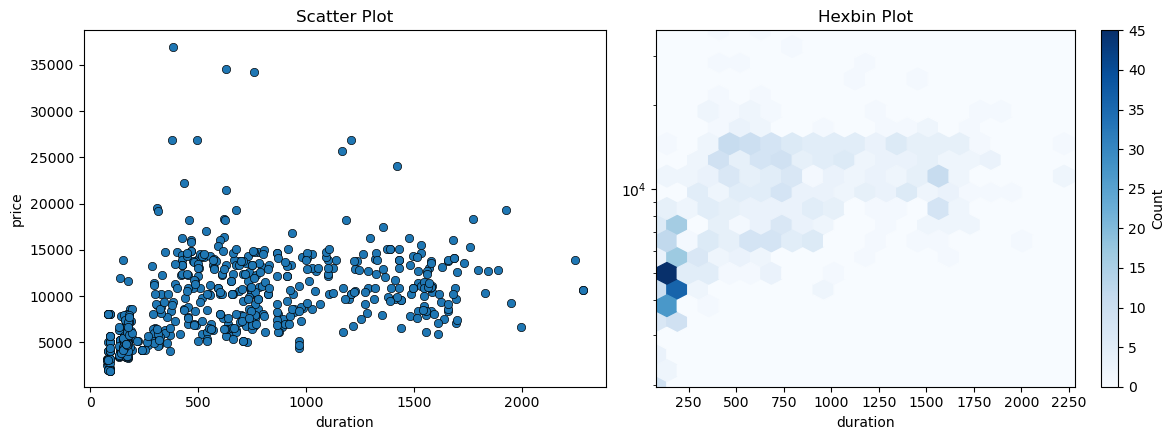

In [37]:
ehf.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale="log",
        gridsize=20,
        cmap="Blues"
    )
)

In [38]:
ehf.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.4850413385724789
- p-value              : 4.481079686199405e-39
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6725217196673342
- p-value              : 1.8605725894680128e-85
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


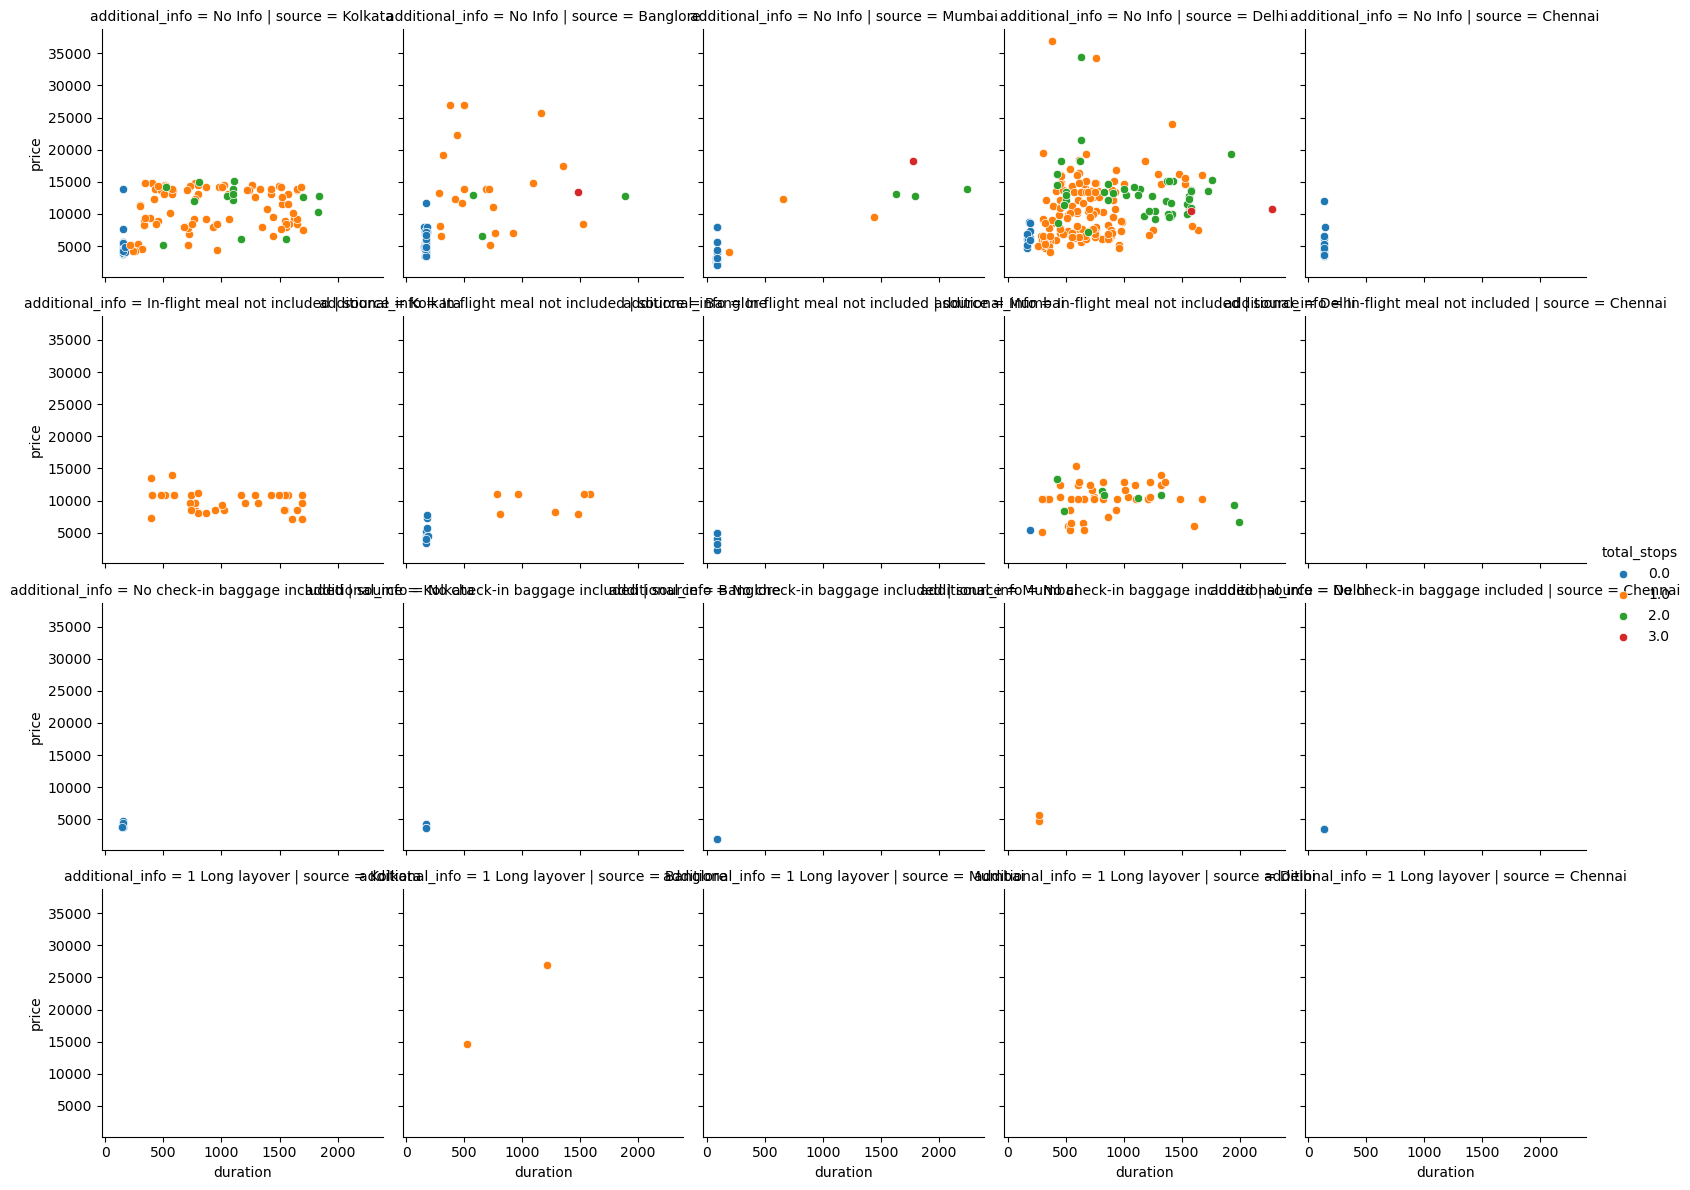

In [39]:
duration_grid = sns.FacetGrid(
    data=train,
    row="additional_info",
    col="source",
    hue="total_stops",
    sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")
duration_grid.add_legend()
plt.tight_layout()

In [40]:
ehf.get_iqr_outliers(train, "duration")

Lower Limit : -977.5
Upper Limit : 2082.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
219,Air India,2019-03-06,Mumbai,Hyderabad,2025-01-22 06:00:00,2025-01-22 19:25:00,2245,2.0,No Info,13904
60,Air India,2019-05-18,Delhi,Cochin,2025-01-22 05:15:00,2025-01-22 19:15:00,2280,3.0,No Info,10703
271,Air India,2019-05-09,Delhi,Cochin,2025-01-22 05:15:00,2025-01-22 19:15:00,2280,3.0,No Info,10703


### 8.5 additional_info

In [41]:
ehf.cat_summary(train, "additional_info")

0                           No Info
1       In-flight meal not included
2       In-flight meal not included
3                           No Info
4       In-flight meal not included
                   ...             
635                         No Info
636                         No Info
637                         No Info
638                         No Info
639    No check-in baggage included
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,4
top,No Info
freq,497


,count,percentage
category,,
No Info,497,0.776563
In-flight meal not included,120,0.187500
No check-in baggage included,21,0.032813
1 Long layover,2,0.003125


## 9. Automated EDA

In [42]:
from ydata_profiling import ProfileReport

In [43]:
report = ProfileReport(train, title="Flights Profiling Report")

In [44]:
report.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]